## Data Prep

**Import necessary modules and the ASOS/SNOTEL dataframes**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dtb
import os
from glob import glob
import datetime as dt
import seaborn as sns
pd.show_versions()
import sys
import graphviz
sys.executable
#import graphviz


INSTALLED VERSIONS
------------------
commit: None
python: 3.6.5.final.0
python-bits: 32
OS: Windows
OS-release: 10
machine: AMD64
processor: Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
byteorder: little
LC_ALL: None
LANG: en_US.UTF-8
LOCALE: None.None

pandas: 0.24.0
pytest: None
pip: 18.1
setuptools: 39.0.1
Cython: None
numpy: 1.14.3
scipy: 1.1.0
pyarrow: None
xarray: None
IPython: 6.4.0
sphinx: None
patsy: 0.5.1
dateutil: 2.7.3
pytz: 2018.4
blosc: None
bottleneck: None
tables: None
numexpr: None
feather: None
matplotlib: 2.2.2
openpyxl: None
xlrd: None
xlwt: None
xlsxwriter: None
lxml.etree: 4.2.5
bs4: None
html5lib: 1.0.1
sqlalchemy: None
pymysql: None
psycopg2: None
jinja2: 2.10
s3fs: None
fastparquet: None
pandas_gbq: None
pandas_datareader: None
gcsfs: None


'c:\\users\\rapp\\appdata\\local\\programs\\python\\python36-32\\python.exe'

In [2]:
data = [pd.read_csv('asos_snotel_UA_12hr_df.dat', parse_dates = True, index_col = 'Date_Time')]
asos_snotel_UA_df = pd.concat(data)
#asos_snotel_UA_df['LXV_WindSpeed_m/s']

#asos_snotel_UA_df.rename(columns={'LXV_WindSpeed_m/s': 'LXV_WindSpeed_mps'}, inplace=True)

asos_snotel_UA_df.astype('float16')
pd.set_option('display.expand_frame_repr', True)


print(asos_snotel_UA_df.keys())




#delete empty columns as they mess up loops
#del asos_snotel_UA_df['CMtn_6hr_Precipitation_mm']            #empty column


Index(['CMtnSNTL_Temp_degC', 'CMtnSNTL_SnowDepth_in', 'CMtn_Temperature_degC',
       'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps',
       'CMtn_CloudCover_oktas', 'CMtn_1hr_Precipitation_mm',
       'LXV_Temperature_degC', 'LXV_Dewpoint_degC',
       ...
       'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc',
       'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts',
       'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc',
       'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts'],
      dtype='object', length=163)


It is important to keep in mind that 'CMtnSNTL_12hr_SNWD_in contains snow depth info taken at the start of the respective 12hr period timestamp.  The snowfall calculated also gives the snowfall that fell in the 12hrs after the timestamp.  The OLS model will utilize hourly meteorological measurements at exactly 00:00 and 12:00 hours to predict the amount of snow which will fall in the next 12 hour period.  For example, the 00:00 meteorological measurements will be used to predict the snow which fell between 00:00 and 12:00.

#### Do a test to make sure some pythonic lines of code work the way I think I do to bring data into a list format for the DecisionTree model

In [3]:
testtrain1 = []
testtrain2 = []
test_vars = ['LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_WindSpeed_mps']


#Method 1 [more pythonic]
loop_idx = np.isfinite(asos_snotel_UA_df['2009':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'])
for v in test_vars:
    loop_idx = loop_idx & np.isfinite(asos_snotel_UA_df['2009':'2017'][v])

gv = pd.DataFrame()
#gv_asos_snotel_UA_df = asos_snotel_UA_df.copy
#gv_asos_snotel_UA_df = asos_snotel_UA_df['2009':'2017'][['LXV_Temperature_degC', 'LXV_WindSpeed_mps', 'LXV_Dewpoint_degC']][loop_idx]
testlist1 = asos_snotel_UA_df['2009':'2017'][['LXV_Temperature_degC', 'LXV_WindSpeed_mps', 'LXV_Dewpoint_degC']][loop_idx].apply(lambda x: x.tolist(), axis=1)
#testtrain2 = testlist.apply(lambda x: testtrain2.append(x))
testtrain1 = testlist1.tolist()


#Method 2 [less pythonic]
# Explicitly list each feature

compare_idx = np.isfinite(asos_snotel_UA_df['2009':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & \
           np.isfinite(asos_snotel_UA_df['2009':'2017']['LXV_Temperature_degC']) & \
           np.isfinite(asos_snotel_UA_df['2009':'2017']['LXV_Dewpoint_degC']) & \
           np.isfinite(asos_snotel_UA_df['2009':'2017']['LXV_WindSpeed_mps'])

for index, rows in asos_snotel_UA_df['2009':'2017'][compare_idx].iterrows(): 
    # Create list for the current row 
    testlist2 =[rows['LXV_Temperature_degC'], rows['LXV_WindSpeed_mps'], rows['LXV_Dewpoint_degC']] 
    # append the list to the final list 
    testtrain2.append(testlist2)
    
print(len(loop_idx), len(compare_idx))
print(loop_idx.equals(compare_idx))
print(testtrain2 == testtrain1)


6574 6574
True
True


# Decision Tree with Surface Features Only

### Now identify variables which have good data capture

In [4]:
variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp']

good_vars_sfc = []
bad_vars_sfc = []
for var in variables:
    idx = np.isfinite(asos_snotel_UA_df['2009':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & np.isfinite(asos_snotel_UA_df['2009':'2017'][var])
    total_poss = len(asos_snotel_UA_df['2009':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df['2009':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=0])
    total_avail =len(asos_snotel_UA_df['2009':'2017'][idx])
    if total_avail/total_poss >= 0.67: 
        good_vars_sfc.append(var)
    else:
        bad_vars_sfc.append(var)

       
print('Variables with >= 67% data match to snowfall: ')
print(good_vars_sfc)
print('Variables with < 67% data match to snowfall: ')
print(bad_vars_sfc)

Variables with >= 67% data match to snowfall: 
['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp']
Variables with < 67% data match to snowfall: 
['CMtn_CloudCover_oktas', 'LXV_CloudCover_oktas']


### Set up test data

In [52]:
#asos_snotel_UA_df['LXV_12hr_delta_Pressure_hp'] = asos_snotel_UA_df['LXV_Pressure_hp']-asos_snotel_UA_df['LXV_Pressure_hp'].shift(+12)
#print(asos_snotel_UA_df['LXV_12hr_delta_Pressure_hp'].describe())
all_yrs = (asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index <= '01-01-2018')
test_yrs = ((asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index <= '12-31-2006')) | ((asos_snotel_UA_df.index >= '01-01-2017') & (asos_snotel_UA_df.index <= '01-01-2018'))
train_yrs = (asos_snotel_UA_df.index >= '01-01-2007') & (asos_snotel_UA_df.index <= '01-01-2017')

print(asos_snotel_UA_df['CMtnSNTL_Temp_degC'].describe())
print(asos_snotel_UA_df[all_yrs]['CMtnSNTL_Temp_degC'].describe())
print(asos_snotel_UA_df[test_yrs]['CMtnSNTL_Temp_degC'].describe())
print(asos_snotel_UA_df[train_yrs]['CMtnSNTL_Temp_degC'].describe())
print(asos_snotel_UA_df['2006']['CMtnSNTL_Temp_degC'].describe())
print(asos_snotel_UA_df['2017']['CMtnSNTL_Temp_degC'].describe())

count    8710.000000
mean       -0.001883
std         8.559429
min       -30.600000
25%        -6.270000
50%         0.000000
75%         7.300000
max        19.100000
Name: CMtnSNTL_Temp_degC, dtype: float64
count    8710.000000
mean       -0.001883
std         8.559429
min       -30.600000
25%        -6.270000
50%         0.000000
75%         7.300000
max        19.100000
Name: CMtnSNTL_Temp_degC, dtype: float64
count    1405.000000
mean        0.694235
std         8.115662
min       -28.100000
25%        -4.800000
50%         0.600000
75%         7.500000
max        18.300000
Name: CMtnSNTL_Temp_degC, dtype: float64
count    7305.000000
mean       -0.135003
std         8.635260
min       -30.600000
25%        -6.470000
50%        -0.100000
75%         7.200000
max        19.100000
Name: CMtnSNTL_Temp_degC, dtype: float64
count    730.000000
mean      -0.112055
std        8.636057
min      -28.100000
25%       -6.600000
50%       -0.100000
75%        7.475000
max       18.300000
Name

In [6]:
Xtest = []
Xtest_feat =[]
Ytest = []
Ytest_actsnf = []
idx_test = []

idx_test = np.isfinite(asos_snotel_UA_df[test_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'])
for v in good_vars_sfc:
    idx_test = idx_test & np.isfinite(asos_snotel_UA_df[test_yrs][v])    
    
print(len(idx_test))
Ytest = round(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][test_yrs][idx_test],0)
Ytest_actsnf  = Ytest.tolist()

gv = pd.DataFrame()
#gv_asos_snotel_UA_df = asos_snotel_UA_df.copy
#gv_asos_snotel_UA_df = asos_snotel_UA_df['2009':'2017'][['LXV_Temperature_degC', 'LXV_WindSpeed_mps', 'LXV_Dewpoint_degC']][loop_idx]
Xtest = asos_snotel_UA_df[test_yrs][good_vars_sfc][idx_test].apply(lambda x: x.tolist(), axis=1)
#testtrain2 = testlist.apply(lambda x: testtrain2.append(x))
Xtest_feat = Xtest.tolist()
print(Xtest_feat[0:5], Ytest_actsnf[0:5])


1458
[[-3.2, -7.0, -8.0, 340.0, 5.1, -4.4, -7.2, 993.4, 2.6, 70.0, -5.2], [-6.2, -9.0, -12.0, 290.0, 10.8, -6.7, -8.9, 1005.8, 4.1, 310.0, -4.2], [-8.2, -9.0, -12.0, 290.0, 7.7, -7.0, -9.0, 1004.3, 1.5, 180.0, -5.4], [-8.0, -9.0, -12.0, 310.0, 7.7, -7.2, -11.1, 1022.6, 1.5, 10.0, -2.4], [-4.3, -8.0, -12.0, 260.0, 9.8, -2.2, -12.2, 1003.9, 3.1, 310.0, -9.0]] [5.0, 4.0, 5.0, 4.0, 5.0]


### Set up training data with 2009-2017 years

In [7]:
Xtrain = []
Xtrain_feat =[]
Ytrain = []
Ytrain_actsnf = []
idx_train = []

idx_train = np.isfinite(asos_snotel_UA_df[train_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'])
for v in good_vars_sfc:
    idx_train = idx_train & np.isfinite(asos_snotel_UA_df[train_yrs][v])    
    
Ytrain = round(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][train_yrs][idx_train],0)
Ytrain_actsnf = Ytrain.tolist()


gv = pd.DataFrame()
#gv_asos_snotel_UA_df = asos_snotel_UA_df.copy
#gv_asos_snotel_UA_df = asos_snotel_UA_df[train_yrs][['LXV_Temperature_degC', 'LXV_WindSpeed_mps', 'LXV_Dewpoint_degC']][loop_idx]
Xtrain = asos_snotel_UA_df[train_yrs][good_vars_sfc][idx_train].apply(lambda x: x.tolist(), axis=1)
#testtrain2 = testlist.apply(lambda x: testtrain2.append(x))
Xtrain_feat = Xtrain.tolist()
    
print(Xtrain_feat[0:5], Ytrain_actsnf[0:5])

    

[[-0.6, -5.0, -10.0, 250.0, 9.3, -0.6, -8.9, 998.6, 1.5, 70.0, -6.0], [-3.2, -7.0, -13.0, 260.0, 6.2, -2.2, -11.1, 1001.1, 3.6, 200.0, 0.5], [-5.0, -8.0, -12.0, 250.0, 3.6, -4.4, -9.4, 997.9, 3.6, 180.0, -5.2], [-4.6, -4.0, -13.0, 220.0, 3.6, -7.2, -12.8, 1013.8, 3.1, 200.0, -4.1], [-3.5, -5.0, -8.0, 200.0, 3.1, -2.8, -6.7, 1014.1, 2.1, 40.0, -3.6]] [6.0, 4.0, 4.0, 3.0, 5.0]


### Run model with suface features only

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
47


Text(0,0.5,'Actual Minus Predicted Snowfall (in)')

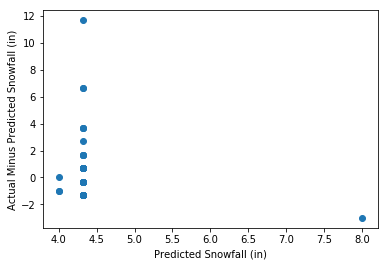

In [8]:
clf =[]
Y_predsnf = []

from sklearn import tree
clf = tree.DecisionTreeRegressor(max_depth=3)
clf = clf.fit(Xtrain_feat, Ytrain_actsnf)

print(clf)

# Predict test set labels
Y_predsnf = clf.predict(Xtest_feat)
# Evaluate test-set accuracy


from sklearn.metrics import accuracy_score
#print(accuracy_score(Ytest_actsnf, Y_predsnf))
#plt.plot(Ytestlist-y_pred) 
print(len(Y_predsnf))

plt.scatter(Y_predsnf, Ytest_actsnf-Y_predsnf)
plt.xlabel('Predicted Snowfall (in)')
plt.ylabel('Actual Minus Predicted Snowfall (in)')

Graphically view

['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp']


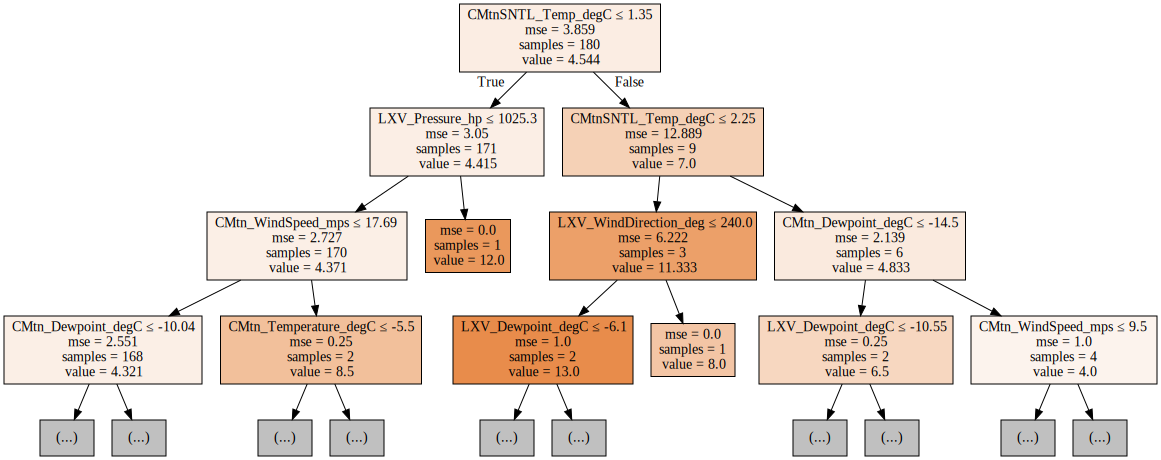

In [25]:
import graphviz 

fn = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K"]
#dot_data = tree.export_graphviz(clf, out_file=None, \
#                                feature_names=['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp'], \
#                                label = 'all', filled = True,special_characters = True, class_names = True, max_depth = 10) 

dot_data = tree.export_graphviz(clf, out_file=None, \
                                feature_names=good_vars_sfc, \
                                label = 'all', filled = True,special_characters = True, class_names = True, max_depth = 3) 


print(good_vars_sfc)
graph = graphviz.Source(dot_data) 
#graph.render() 
#dot_data = tree.export_graphviz(clf, out_file=None, 
#                      feature_names=iris.feature_names,  
#                      class_names=iris.target_names,  
#                      filled=True, rounded=True,  
#                      special_characters=True)

#dot_data = tree.export_graphviz(clf)
tree.export_graphviz(clf)
graph = graphviz.Source(dot_data)  
graph 

Try max depth 10

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
6.9881404689535405
47


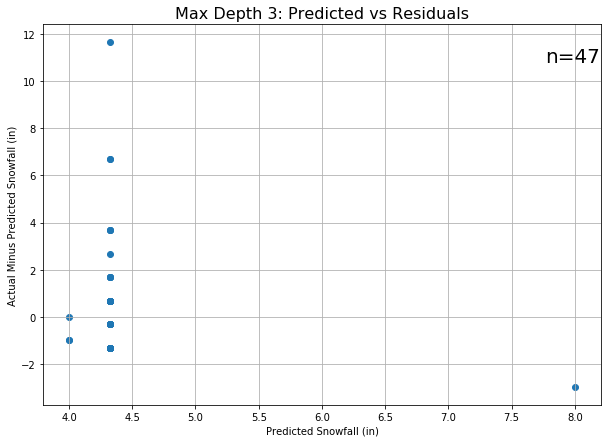

In [67]:
clf =[]
Y_predsnf = []

from sklearn import tree
clf = tree.DecisionTreeRegressor(max_depth=3)
clf = clf.fit(Xtrain_feat, Ytrain_actsnf)

print(clf)

# Predict test set labels
Y_predsnf = clf.predict(Xtest_feat)
# Evaluate test-set accuracy


from sklearn.metrics import mean_squared_error
print(mean_squared_error(Ytest_actsnf, Y_predsnf))
#plt.plot(Ytestlist-y_pred) 


fig = plt.figure(figsize=(10,7))
plt.scatter(Y_predsnf, Ytest_actsnf-Y_predsnf)
plt.xlabel('Predicted Snowfall (in)')
plt.ylabel('Actual Minus Predicted Snowfall (in)')
plt.grid(True)


plt.annotate('n=' + str(len(Y_predsnf)), xy=(0.9, 0.9), xycoords='axes fraction', fontsize=20)

print(len(Y_predsnf))

plt.title('Max Depth 3: Predicted vs Residuals', fontsize = 16)

plt.savefig('C:/Users/RAPP/Documents/Capstone/MS_CS_report/figs/TREE_pred_vs_residuals_SFC.png',bbox_inches='tight')

Try multpile max depths

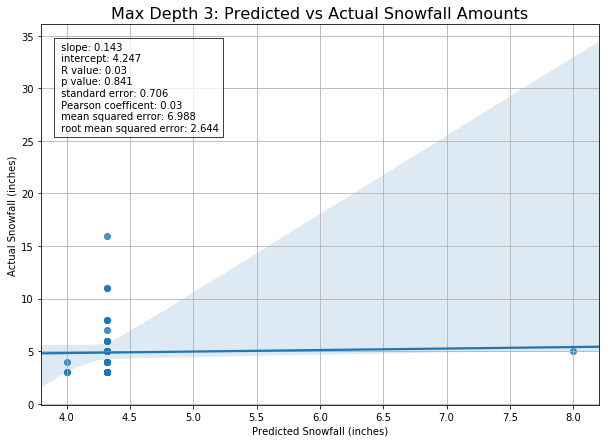

In [68]:
from scipy.stats import pearsonr, linregress
from sklearn.metrics import mean_squared_error


fig = plt.figure(figsize=(10,7))

## Do linear regression and calculate slope, intercept, r, p, std err
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(Y_predsnf, Ytest_actsnf)
#Calculate mse and rmse
mse = mean_squared_error(Y_predsnf, Ytest_actsnf)
rmse = np.sqrt(mse)
pearson1, pv = pearsonr(Y_predsnf, Ytest_actsnf)

#plot and annotate
sns.regplot(Y_predsnf, Ytest_actsnf)
bbox_props=dict(facecolor='red', alpha=0.75, fc = 'white')
plt.annotate(' slope: ' + str(round(slope1,3)) +
                 '\n intercept: ' + str(round(intercept1,3)) + 
                 '\n R value: ' + str(round(r_value1,3)) +  
                 '\n p value: ' + str(round(p_value1,3)) + 
                 '\n standard error: ' + str(round(std_err1,3)) +
                 '\n Pearson coefficent: ' + str(round(pearson1,3)) +
                 '\n mean squared error: ' + str(round(mse,3)) +
                 '\n root mean squared error: ' + str(round(rmse,3)), \
                 xy=(0.03, 0.72), xycoords='axes fraction', fontsize=10, bbox = bbox_props)

plt.xlabel('Predicted Snowfall (inches)')
plt.ylabel('Actual Snowfall (inches)')
#plt.xlim([3,6])
#plt.ylim([-3,16])
plt.grid(True)
plt.title('Max Depth 3: Predicted vs Actual Snowfall Amounts', fontsize = 16)

plt.savefig('C:/Users/RAPP/Documents/Capstone/MS_CS_report/figs/TREE_pred_vs_act_SFC.png',bbox_inches='tight')

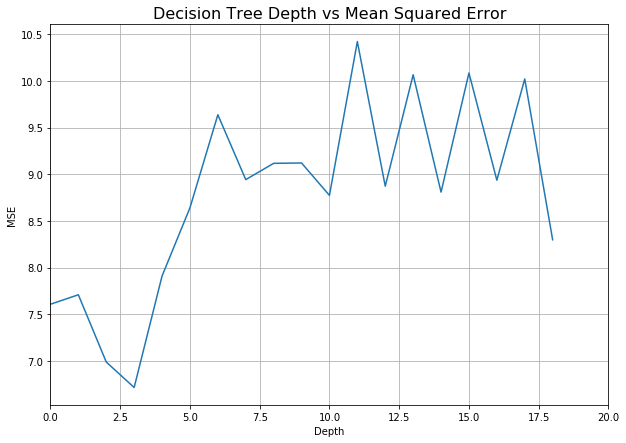

In [60]:
from sklearn import tree
from sklearn.metrics import accuracy_score
mse = []

for i in range(1,20):
  clf = []
  clf = tree.DecisionTreeRegressor(max_depth=i)
  clf = clf.fit(Xtrain_feat, Ytrain_actsnf)

#print(clf)

# Predict test set labels
  Y_predsnf = clf.predict(Xtest_feat)
# Evaluate test-set accuracy


  mse.append(mean_squared_error(Ytest_actsnf, Y_predsnf))
#plt.plot(Ytestlist-y_pred) 


fig = plt.figure(figsize=(10,7))
plt.plot(mse)
plt.xlabel('Depth')
plt.ylabel('MSE')
plt.xlim(0,20)
plt.grid(True)
#plt.scatter(y_pred, Ytestlist-y_pred)
plt.title('Decision Tree Depth vs Mean Squared Error', fontsize = 16)

plt.savefig('C:/Users/RAPP/Documents/Capstone/MS_CS_report/figs/TREE_depth_vs_mse_SFC.png',bbox_inches='tight')

180


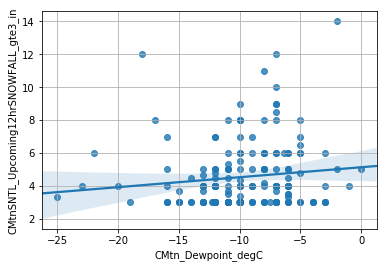

In [15]:
#plt.plot(Ytest_actsnf)
#asos_snotel_UA_df[train_yrs][good_vars_sfc][idx_train]
print(len(asos_snotel_UA_df[train_yrs]['CMtn_Dewpoint_degC'][idx_train]))
sns.regplot(asos_snotel_UA_df[train_yrs]['CMtn_Dewpoint_degC'][idx_train], asos_snotel_UA_df[train_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][idx_train])
plt.grid(True)

47


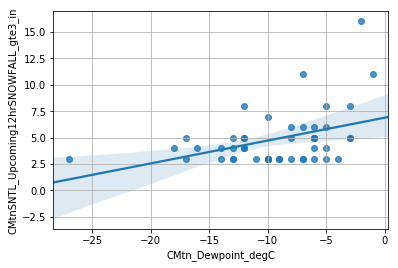

In [16]:
print(len(asos_snotel_UA_df[test_yrs]['CMtn_Dewpoint_degC'][idx_test]))
sns.regplot(asos_snotel_UA_df[test_yrs]['CMtn_Dewpoint_degC'][idx_test], asos_snotel_UA_df[test_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][idx_test])
plt.grid(True)